#### Construir um Bag of Visual Words compreende três passos:
- 1. Extração de features: Extração das features das imagens usando ORB;
- 2. Construção de dicionário: É utilizado o algoritmo de agrupamento K-means. Os centroides obtidos são as palavras chaves;
- 3. Quantização de vetor: É criado um histograma para representar a frequência de cada palavra visual.

### Import de bibliotecas

In [1]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans,vq # Esse módulo é utilizado para quantização vetorial para usar com o K-Means
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage import  data, color, feature
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
import pandas as pd #
import random

## Carregamento de dataset e extração de features

In [2]:
'''
Função para salvar estrutura de dados
em extensão .pckl para posterior uso
'''
def save_data(data, save_path):
    with open(save_path, 'wb') as f:
        pickle.dump(data, f)

'''
Função para carregar estrutura de dados
salva em extensão .pckl
'''
def load_data(data_path):
    with open(data_path, 'rb') as f:
        return pickle.load(f)

'''
Função para extração de features
usando ORB
'''
def get_orb_features(img):
    orb = cv2.ORB_create()
    kp = orb.detect(img,None)
    kp, des = orb.compute(img, kp)
    return des


def get_sift_features(img):
    orb = cv2.ORB_create()
    kp = orb.detect(img,None)
    kp, des = orb.compute(img, kp)
    return des
    
'''
Função para carregamento de dataset
Recebe o diretório das imagens e,
opcionalmente, faz o resize delas.
Optou-se pelo resize por conta dos
recursos computacionais.
'''
def load_dataset(folder_path, save = True, 
                 save_path = './dataset/dataset.pkl',
                resize = True, resolution = (150,150)):
    dataset = []
    for filename in os.listdir(folder_path):
        path = folder_path + '/' + filename
        print('== >', filename)
        for img_path in os.listdir(path):
            # Carrega imagem em escala de cinza para posterior processamento
            img = cv2.imread(path + '/' + img_path, 0)
            if img is not None:
                if resize:
                    img = cv2.resize(img, resolution)
                # Obtém os descritores a partir do orb
                orb_descriptor = get_orb_features(img)
                #hog_descriptor = get_hog(img)
                
                if orb_descriptor is not None:
                    if("butterfly" in filename):
                        class_index = 0 #ok **50%
                    elif("cat" in filename):
                        class_index = 1
                    elif("chicken" in filename):
                        class_index = 2 # ok
                    elif("cow" in filename):
                        class_index = 3 #ok
                    elif("dog" in filename):
                        class_index = 4 # ok
                    elif("elephant" in filename):
                        class_index = 5 # ok
                    elif("horse" in filename):
                        class_index = 6 # ok
                    elif("ragno" in filename):
                        class_index = 7 #  ok
                    elif("sheep" in filename):
                        class_index = 8 # ok
                    elif("squirrel" in filename):
                        class_index = 9 #
                    dataset.append((orb_descriptor, class_index))
    if save:
        save_data(dataset, save_path)
    return dataset

In [3]:
'''
Função utilizada para separar os dados de treino e teste
80% são usados para treino, enquanto que os 30% para teste
'''
def split_dataset(dataset, test_size=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size)
    train_data = [dataset[i] for i in train_idx]
    test_data = [dataset[i] for i in val_idx]
    
    data_train, y_train = zip(*train_data)
    data_test, y_test = zip(*test_data)
    
    return data_train, y_train, data_test, y_test

'''
Nessa função, ocorre a construção do vocabulário de
palavras visuais. Para isso, é utilizado o algoritmo 
k-means, que é responsável por agrupar o vetor de 
features obtidos a partir do ORB. Os centróides desse 
agrupamento são usados como dicionário de palavras 
visuais. Para cada vetor extraído, é calculado o seu 
vizinho mais próximo no dicionário criado com o K-means. 
A partir disso, é criado um histograma de comprimento k 
(número de clusters de K-means), que representa a 
frequência de cada palavra visual.
'''

def get_bovw(data, k = 150, save=True, save_path = './dataset/extracted_feature.pkl'):
    #Empilha o array de vetores para vertical 
    descriptors=data[0]
    for descriptor in data[1:]:
        descriptors=np.vstack((descriptors,descriptor))
     
    
    descriptors_float=descriptors.astype(float)
    
    # Executa k-means em um conjunto de vetores para
    # obtenção de k clusters.
    # Recebe o array de descritores de cada imagem, o 
    # valor de k clusters e **
    
    # Retorna os centróides calculados e o valor médio
    # da distância Euclidiana entre as observações e o
    # centroid
    centroids,centroid_distance=kmeans(descriptors_float,k)
    
    # Constroi o histograma de features
    # correspondente a cada imagem
    im_features=np.zeros((len(data),k),"float32")
    for i in range(len(data)):
        # Mapeia as observações para os centróides
        # apropriados que são calculados no método
        # kmeans. Recebe como parâmetros o descritor
        # e o dicionário de palavras visuais
        
        # Retorna o índice no dicionário que corresponde
        # o descritor e a distânia entre o descritor e 
        # seu centróide
        words,distance=vq(data[i],centroids)
        for w in words:
            im_features[i][w]+=1
            
    # Normaliza as features obtidas
    stdslr=StandardScaler().fit(im_features)
    im_features=stdslr.transform(im_features)
            
    if save:
        save_data(im_features, save_path)
    return im_features

In [4]:
data_train = load_data('./dataset/data_train.pkl');
y_train = load_data('./dataset/y_train.pkl');
data_test = load_data('./dataset/data_test.pkl');
y_test = load_data('./dataset/y_test.pkl');

In [5]:
#Para testar o método, inicialmente treinei com duas classes, apenas. Infelizmente, não tive tempo de prosseguir com as demais classes

# Carregamento de dataset
dataset = load_dataset('./dataset/temp', save = False, resize = False)
#dataset = load_data('./dataset/dataset.pkl')
# Divisão em treino e teste
data_train, y_train, data_test, y_test = split_dataset(dataset)

== > dog
== > cat


In [9]:
data_train.shape

(2714, 60)

In [6]:
data_train = get_bovw(data_train, k = 60, save_path = './dataset/data_train.pkl')
data_test = get_bovw(data_test, k = 60, save_path = './dataset/data_test.pkl')

In [7]:
#salvar labels
save_data(y_train, './dataset/y_train.pkl')
save_data(y_test, './dataset/y_test.pkl')

# Treinamento SVM

In [27]:
clf=LinearSVC(max_iter=80000)
clf.fit(data_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=80000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [28]:
predictions_svm = clf.predict(data_test)

### Precisao

In [29]:
acc_svm = accuracy_score(y_test, predictions_svm)
acc_svm

0.5094501718213058

### Matriz de confusão

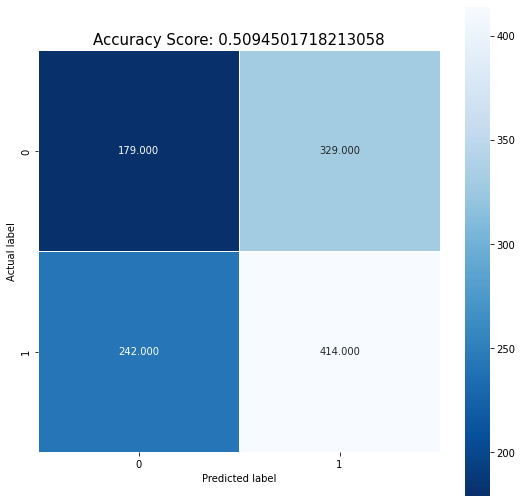

In [21]:
import seaborn as sns

cm = confusion_matrix(y_test, predictions_svm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

#### F1 Score

In [23]:
from sklearn.metrics import f1_score

score = f1_score(y_test, predictions_svm, average="macro")
score

0.48860596258591593

### Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

y_score = clf._predict_proba_lr(data_test)
# precision recall curve
precision = dict()
recall = dict()
for i in range(len(y_test)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# Treinamento KNN

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(data_train, np.array(y_train))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [15]:
predictions_knn = model.predict(data_test)

### Precisao

In [16]:
acc_knn = accuracy_score(y_test, predictions_knn)
acc_knn

0.5481099656357389

### Matriz de confusão

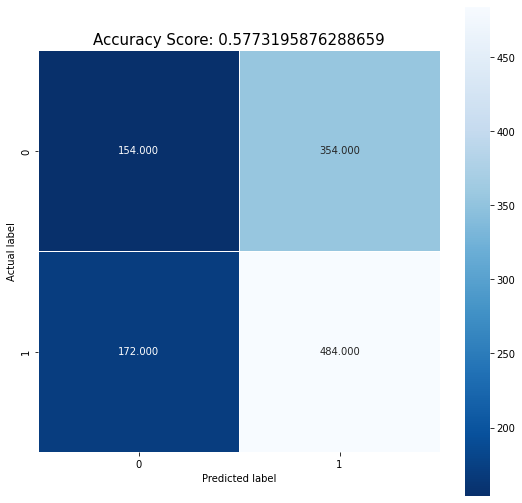

In [18]:
cm = confusion_matrix(y_test, predictions_knn)

import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

#### F1 Score

In [20]:
score = f1_score(y_test, predictions_knn, average="macro")
score

0.5086147949110591

### Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

# Treinamento Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=8000000)
logisticRegr.fit(data_train_norm, np.array(new_y_train))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [84]:
predictions_lr = model.predict(data_test)

### Precisao

In [87]:
acc = accuracy_score(new_y_test, predictions_lr)
acc

0.9841836734693877

### Matriz de confusão

In [ ]:
cm = confusion_matrix(y_test, predictions_svm)

import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_svm)
plt.title(all_sample_title, size = 15);

#### F1 Score

In [ ]:
from sklearn.metrics import f1_score

score = f1_score(true_labels, pred_labels, average="macro")

### Precision Recall Curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve

# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()